In [82]:
%load_ext zipline
%load_ext watermark
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [83]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)
# комиссии
from zipline.finance import commission

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, date

# aинансовые данные
from yahoofinancials import YahooFinancials

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
from matplotlib import mlab
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
%matplotlib inline

plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 200

#векторный формат
%config InlineBackend.figure_format = 'svg'

from tqdm import tqdm

# Прогружаем данные

In [84]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close', 'adjclose', 'volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1
    df = df.resample("1d").mean()
    df.fillna(method="ffill", inplace=True)
    df['pct_diff'] = df['adjclose'].pct_change() * 100

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.adjclose.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green', fontsize=9);

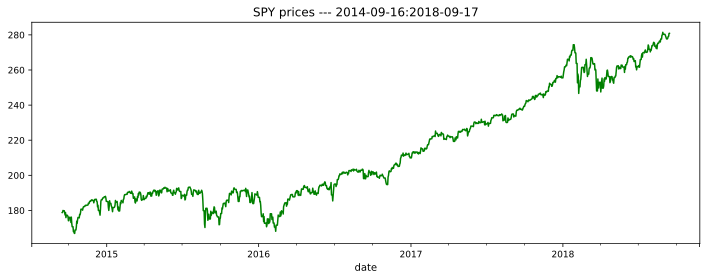

In [85]:
download_csv_data(ticker='SPY', 
                  start_date='2014-09-16', 
                  end_date='2018-09-17', 
                  freq='daily', 
                  path='data/SPY.csv')

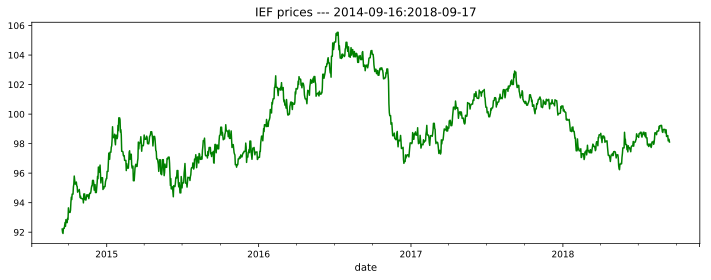

In [86]:
download_csv_data(ticker='IEF', 
                  start_date='2014-09-16', 
                  end_date='2018-09-17', 
                  freq='daily', 
                  path='data/IEF.csv')

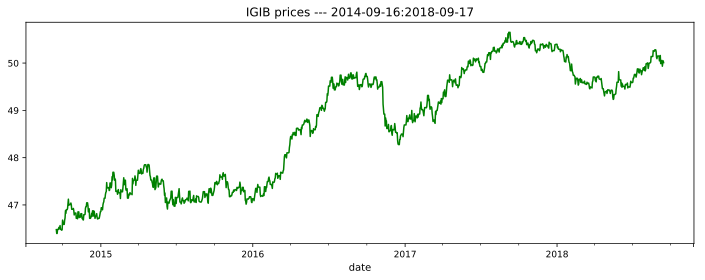

In [87]:
download_csv_data(ticker='IGIB', 
                  start_date='2014-09-16', 
                  end_date='2018-09-17', 
                  freq='daily', 
                  path='data/IGIB.csv')

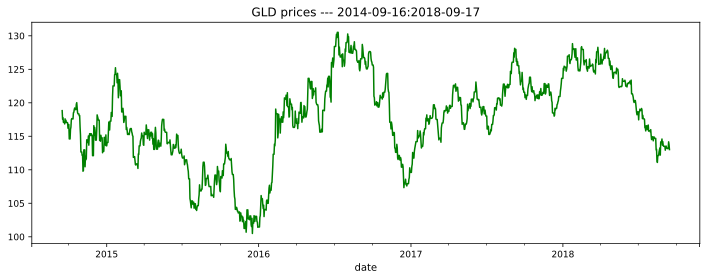

In [88]:
download_csv_data(ticker='GLD', 
                  start_date='2014-09-16', 
                  end_date='2018-09-17', 
                  freq='daily', 
                  path='data/GLD.csv')

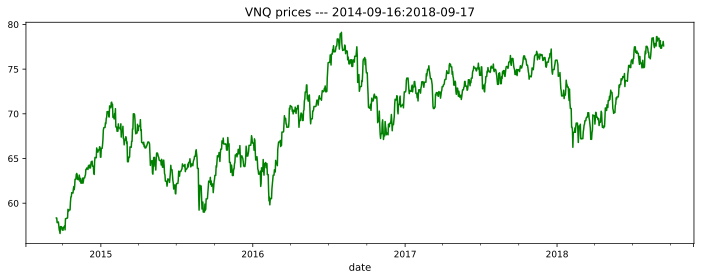

In [89]:
download_csv_data(ticker='VNQ', 
                  start_date='2014-09-16', 
                  end_date='2018-09-17',
                  freq='daily', 
                  path='data/VNQ.csv')

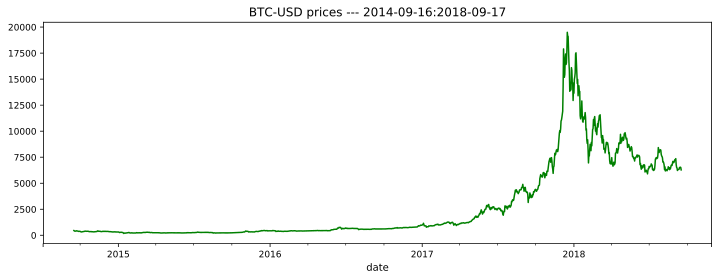

In [90]:
download_csv_data(ticker='BTC-USD', 
                  start_date='2014-09-16', 
                  end_date='2018-09-17',
                  freq='daily', 
                  path='data/BTC.csv')

In [91]:
# Список финансовых инструментов в портфеле
TIKERS = ['SPY', 'IEF', 'IGIB', 'GLD', 'VNQ', 'BTC']

In [92]:
# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose', 'pct_diff']

data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].head())
        
COLUMNS = ['open', 'close', 'pct_diff']

                  open       close  pct_diff
date                                        
2014-09-16  178.784531  178.784531       NaN
2014-09-17  179.025345  179.025345  0.134695
2014-09-18  179.979568  179.979568  0.533010
2014-09-19  179.817352  179.817352 -0.090130
2014-09-20  179.817352  179.817352  0.000000
                 open      close  pct_diff
date                                      
2014-09-16  92.211517  92.211517       NaN
2014-09-17  91.978523  91.978523 -0.252674
2014-09-18  91.915764  91.915764 -0.068233
2014-09-19  92.265274  92.265274  0.380251
2014-09-20  92.265274  92.265274  0.000000
                 open      close  pct_diff
date                                      
2014-09-16  46.477493  46.477493       NaN
2014-09-17  46.396721  46.396721 -0.173788
2014-09-18  46.396721  46.396721  0.000000
2014-09-19  46.481754  46.481754  0.183275
2014-09-20  46.481754  46.481754  0.000000
                  open       close  pct_diff
date                                  

In [93]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 6 (items) x 1462 (major_axis) x 3 (minor_axis)
Items axis: SPY to BTC
Major_axis axis: 2014-09-16 00:00:00+00:00 to 2018-09-16 00:00:00+00:00
Minor_axis axis: open to pct_diff


# Взаимная корреляция

In [94]:
data_corr = data['SPY']
for tiker in TIKERS:
    data_corr[tiker] = data[tiker]['pct_diff']
del data_corr['open']
del data_corr['close']
del data_corr['pct_diff']
data_corr.corr(method='pearson')

,SPY,IEF,IGIB,GLD,VNQ,BTC
SPY,1.000000,-0.367854,-0.140857,-0.139176,0.572779,0.018888
IEF,-0.367854,1.000000,0.851808,0.411837,0.109680,-0.018519
IGIB,-0.140857,0.851808,1.000000,0.378711,0.213747,-0.009154
GLD,-0.139176,0.411837,0.378711,1.000000,0.053369,0.009437
VNQ,0.572779,0.109680,0.213747,0.053369,1.000000,-0.002501
BTC,0.018888,-0.018519,-0.009154,0.009437,-0.002501,1.000000


In [95]:
data_corr.corr(method='kendall')

,SPY,IEF,IGIB,GLD,VNQ,BTC
SPY,1.000000,-0.236163,-0.109328,-0.085091,0.341022,0.004435
IEF,-0.236163,1.000000,0.684819,0.293004,0.040862,-0.008643
IGIB,-0.109328,0.684819,1.000000,0.263173,0.107698,-0.001966
GLD,-0.085091,0.293004,0.263173,1.000000,0.031164,-0.001741
VNQ,0.341022,0.040862,0.107698,0.031164,1.000000,-0.005071
BTC,0.004435,-0.008643,-0.001966,-0.001741,-0.005071,1.000000


In [96]:
data_corr.corr(method='spearman')

,SPY,IEF,IGIB,GLD,VNQ,BTC
SPY,1.000000,-0.314563,-0.150238,-0.112049,0.452484,0.006005
IEF,-0.314563,1.000000,0.816703,0.381331,0.063867,-0.012916
IGIB,-0.150238,0.816703,1.000000,0.345414,0.147684,-0.003556
GLD,-0.112049,0.381331,0.345414,1.000000,0.049495,-0.002393
VNQ,0.452484,0.063867,0.147684,0.049495,1.000000,-0.006674
BTC,0.006005,-0.012916,-0.003556,-0.002393,-0.006674,1.000000


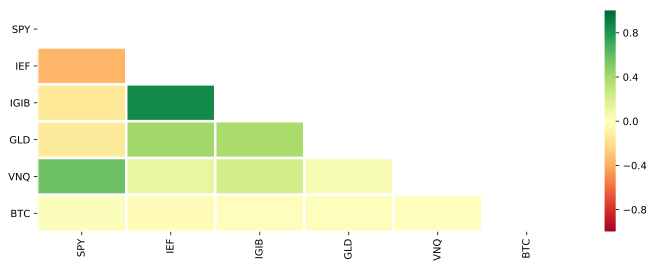

In [97]:
import seaborn
#take the bottom triangle since it repeats itself
mask = np.zeros_like(data_corr.corr())
mask[np.triu_indices_from(mask)] = True
#generate plot
seaborn.heatmap(data_corr.corr(), cmap='RdYlGn', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5)
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()